# Deep learning techniques to identify the composer of a music piece

**Objective**  
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

**Dataset**  
The project will use a dataset consisting of musical scores from various composers. The dataset contain MIDI files and sheet music of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. The dataset should be labeled with the name of the composer for each score.

## Data Collection

### Install required libraries

In [2]:
# Import all dependent libraries
import os
import csv
import zipfile
import shutil

from pathlib import Path
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import keras.optimizers
import tensorflow as tf


# Music related libraries
import music21
from music21 import converter, instrument, note, chord, tempo
import pretty_midi

from collections import Counter

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Deep Learning Libraries
from keras.models import Sequential,load_model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences # not used , should we remove it?
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/Users/johnny/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Function to check if running from colab
def is_running_on_colab():
  return 'google.colab' in str(get_ipython())

if is_running_on_colab():
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive' , force_remount=True)
  root_path = '/content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project'
else:
  print('Not running on Colab')
  root_path = '.'

Not running on Colab


In [4]:
# File path in Google Drive
file_path = os.path.join(root_path, 'Composer_Dataset.zip')

# Extract file path
# Check if Kaggle dataset already exists
extract_path = os.path.join(root_path, 'Kaggle_Composer_Dataset')

if not os.path.exists(extract_path):
    extract_path = os.path.join(root_path, 'Composer_Dataset')

print(f"Using dataset: {extract_path}")

# Dataset folders
path = Path(extract_path)
if "Kaggle_Composer_Dataset" in path.name:
    dataset_path = extract_path
else:
    dataset_path = os.path.join(extract_path, 'Composer_Dataset/NN_midi_files_extended')
print(f"Using extracted dataset: {dataset_path}")

# CSV index file
csv_file = os.path.join(dataset_path, 'composer_dataset_index.csv')

Using dataset: ./Kaggle_Composer_Dataset
Using extracted dataset: ./Kaggle_Composer_Dataset


In [5]:
# Check if folder already exists
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [6]:
# Function to clean the folders
def delete_hidden_folders(root_folder):
    for root, dirs, _ in os.walk(root_folder):
        for d in dirs:
            if d.startswith('.'):
                dir_path = os.path.join(root, d)
                print(f"Deleting hidden folder: {dir_path}")
                shutil.rmtree(dir_path)
            elif d == '__MACOSX':
                dir_path = os.path.join(root, d)
                print(f"Deleting __MACOSX folder: {dir_path}")
                shutil.rmtree(dir_path)

# Run this on the outer Composer_Dataset
delete_hidden_folders(extract_path)

## Data Pre-processing

In [35]:
# Function to create index files
def create_midi_file_index_csv(root_dir, output_csv):
    rows = []

    path = Path(root_dir)
    if "Kaggle_Composer_Dataset" in path.name:
        split_folders = ['train', 'test', 'val']
    else:
        split_folders = ['train', 'test', 'dev']

    for split in split_folders:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue

        for composer in os.listdir(split_path):
            composer_path = os.path.join(split_path, composer)
            if not os.path.isdir(composer_path) or composer.startswith('.'):
                continue

            for filename in os.listdir(composer_path):
                if not filename.endswith('.mid') or filename.startswith('.'):
                    continue

                filepath = os.path.join(split, composer, filename)
                rows.append({
                    'split': split,
                    'composer': composer,
                    'filename': filename,
                    'filepath': filepath
                })

    # Write to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['split', 'composer', 'filename', 'filepath'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"CSV created: {output_csv} with {len(rows)} entries.")

In [36]:
# Create index csv file
create_midi_file_index_csv(root_dir=dataset_path, output_csv=csv_file)

CSV created: ./Kaggle_Composer_Dataset/composer_dataset_index.csv with 1660 entries.


## Feature Extraction

In [52]:
# Define feature extraction function
def extract_midi_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        num_instruments = len(midi_data.instruments)
        notes = [note for inst in midi_data.instruments if not inst.is_drum for note in inst.notes]
        if not notes:
            raise ValueError("No notes found.")

        velocities = [note.velocity for note in notes]
        start_times = [note.start for note in notes]
        end_times = [note.end for note in notes]
        pitches = [note.pitch for note in notes]
        durations = [e - s for s, e in zip(start_times, end_times)]

        onsets = sorted(start_times)
        offsets = sorted(end_times)

        avg_velocity = np.mean(velocities)
        max_velocity = np.max(velocities)
        velocity_variance = np.var(velocities)
        pitch_variance = np.var(pitches)
        avg_interval = np.mean(np.diff(sorted(pitches))) if len(pitches) > 1 else 0
        avg_note_duration = np.mean(durations)
        note_density = len(notes) / midi_data.get_end_time() if midi_data.get_end_time() else 0
#        polyphony = np.mean([len(midi_data.get_active_notes(t)) for t in start_times])
        polyphony_list = []
        for i in range(len(onsets)):
            count = sum(1 for s, e in zip(onsets, offsets) if s <= onsets[i] < e)
            polyphony_list.append(count)

        polyphony = np.mean(polyphony_list)        
        rhythmic_density = len(set(start_times)) / midi_data.get_end_time() if midi_data.get_end_time() else 0

        pitch_classes = np.zeros(12)
        for p in pitches:
            pitch_classes[p % 12] += 1
        pitch_classes /= len(pitches)

        #chord_density = sum(1 for t in np.arange(0, midi_data.get_end_time(), 0.5)
        #                    if len(midi_data.get_chords(t, t + 0.5)) > 0) / midi_data.get_end_time()
        # Approximate chord_density by counting overlapping notes (3+ notes = chord)
        time_grid = np.arange(0, midi_data.get_end_time(), 0.5)
        chord_count = 0

        for t in time_grid:
            active_notes = [note for note in notes if note.start <= t < note.end]
            if len(active_notes) >= 3:
                chord_count += 1

        chord_density = chord_count / len(time_grid) if len(time_grid) > 0 else 0

        pitch_transitions = np.mean(np.abs(np.diff(pitches))) if len(pitches) > 1 else 0
        tempo = midi_data.get_tempo_changes()[1].mean() if len(midi_data.get_tempo_changes()[1]) > 0 else 120
        key_sig = midi_data.key_signature_changes
        Key = key_sig[0].key_number if key_sig else np.nan

        return {
            "num_instruments": num_instruments,
            "velocity_variance": velocity_variance,
            "polyphony": polyphony,
            "pitch_variance": pitch_variance,
            "note_density": note_density,
            "pitch_class_0": pitch_classes[0],
            "pitch_class_1": pitch_classes[1],
            "pitch_class_2": pitch_classes[2],
            "pitch_class_3": pitch_classes[3],
            "pitch_class_4": pitch_classes[4],
            "pitch_class_5": pitch_classes[5],
            "pitch_class_6": pitch_classes[6],
            "pitch_class_7": pitch_classes[7],
            "pitch_class_8": pitch_classes[8],
            "pitch_class_9": pitch_classes[9],
            "pitch_class_10": pitch_classes[10],
            "pitch_class_11": pitch_classes[11],
            "avg_velocity": avg_velocity,
            "chord_density": chord_density,
            "max_velocity": max_velocity,
            "avg_interval": avg_interval,
            "rhythmic_density": rhythmic_density,
            "tempo": tempo,
            "avg_note_duration": avg_note_duration,
            "pitch_transitions": pitch_transitions,
            "Key": Key
        }
    except Exception as e:
        print(f"Error parsing {midi_path}: {e}")
        return {f: np.nan for f in [
            "num_instruments", "velocity_variance", "polyphony", "pitch_variance", "note_density",
            "pitch_class_0", "pitch_class_1", "pitch_class_2", "pitch_class_3", "pitch_class_4",
            "pitch_class_5", "pitch_class_6", "pitch_class_7", "pitch_class_8", "pitch_class_9",
            "pitch_class_10", "pitch_class_11", "avg_velocity", "chord_density", "max_velocity",
            "avg_interval", "rhythmic_density", "tempo", "avg_note_duration", "pitch_transitions",
            "Key"
        ]}


In [54]:
# Load your previously generated CSV
df = pd.read_csv(csv_file)

# Extract features
tqdm.pandas(desc="Extracting MIDI Features")
features_df = df["filepath"].progress_apply(lambda path: pd.Series(extract_midi_features(str(Path(dataset_path) / path))))
full_df = pd.concat([df, features_df], axis=1)

# Write it to the csv file
full_df.to_csv(csv_file, index=False)

# Print
full_df.head()

Extracting MIDI Features:   1%|            | 13/1660 [00:23<1:05:35,  2.39s/it]

Error parsing Kaggle_Composer_Dataset/train/Mozart/Mozart_0048.mid: Could not decode key with 2 flats and mode 2


Extracting MIDI Features:   6%|▋          | 103/1660 [02:48<1:02:46,  2.42s/it]/Users/johnny/Library/Python/3.9/lib/python/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting MIDI Features:  85%|██████████▏ | 1404/1660 [25:03<01:10,  3.65it/s]

Error parsing Kaggle_Composer_Dataset/val/Chopin/Chopin_0137.mid: MThd not found. Probably not a MIDI file


Extracting MIDI Features:  86%|██████████▎ | 1431/1660 [25:55<05:57,  1.56s/it]

Error parsing Kaggle_Composer_Dataset/val/Beethoven/Beethoven_0004.mid: Could not decode key with 3 flats and mode 255


Extracting MIDI Features: 100%|████████████| 1660/1660 [27:14<00:00,  1.02it/s]


,split,composer,filename,filepath,num_instruments,velocity_variance,polyphony,pitch_variance,note_density,pitch_class_0,...,pitch_class_11,avg_velocity,chord_density,max_velocity,avg_interval,rhythmic_density,tempo,avg_note_duration,pitch_transitions,Key
0,train,Mozart,Mozart_0103.mid,train/Mozart/Mozart_0103.mid,10.0,416.877661,9.043739,163.539849,25.055833,0.046735,...,0.107849,84.384062,0.831461,105.0,0.017381,3.633021,120.259253,0.268799,3.400959,0.0
1,train,Mozart,Mozart_0063.mid,train/Mozart/Mozart_0063.mid,6.0,203.893338,8.381113,150.448508,12.640908,0.173693,...,0.089376,83.380270,0.893617,115.0,0.046414,3.538602,71.333406,0.488797,4.438819,0.0
2,train,Mozart,Mozart_0077.mid,train/Mozart/Mozart_0077.mid,2.0,189.444842,2.433950,109.876640,9.172174,0.128961,...,0.010041,64.232507,0.346763,110.0,0.018832,6.133010,153.984159,0.231632,3.724733,10.0
3,train,Mozart,Mozart_0088.mid,train/Mozart/Mozart_0088.mid,1.0,0.000000,1.000000,26.531122,5.299415,0.165899,...,0.092166,88.000000,0.000000,88.0,0.048499,5.299415,120.000000,0.142209,3.251732,0.0
4,train,Mozart,Mozart_0248.mid,train/Mozart/Mozart_0248.mid,11.0,804.178713,10.103871,159.927506,32.789952,0.194032,...,0.099954,108.315417,0.860246,127.0,0.003745,7.384256,64.074865,0.212880,3.218874,0.0


## Exploratory Data Analysis

### Dataset overview

In [12]:
# Load the uploaded dataset
df = pd.read_csv(csv_file)

# Show basic info
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   split              1660 non-null   object 
 1   composer           1660 non-null   object 
 2   filename           1660 non-null   object 
 3   filepath           1660 non-null   object 
 4   num_instruments    1657 non-null   float64
 5   velocity_variance  1657 non-null   float64
 6   polyphony          1657 non-null   float64
 7   pitch_variance     1657 non-null   float64
 8   note_density       1657 non-null   float64
 9   pitch_class_0      1657 non-null   float64
 10  pitch_class_1      1657 non-null   float64
 11  pitch_class_2      1657 non-null   float64
 12  pitch_class_3      1657 non-null   float64
 13  pitch_class_4      1657 non-null   float64
 14  pitch_class_5      1657 non-null   float64
 15  pitch_class_6      1657 non-null   float64
 16  pitch_class_7      1657 

,split,composer,filename,filepath,num_instruments,velocity_variance,polyphony,pitch_variance,note_density,pitch_class_0,...,pitch_class_11,avg_velocity,chord_density,max_velocity,avg_interval,rhythmic_density,tempo,avg_note_duration,pitch_transitions,Key
0,train,Mozart,Mozart_0103.mid,train/Mozart/Mozart_0103.mid,10.0,416.877661,9.043739,163.539849,25.055833,0.046735,...,0.107849,84.384062,0.831461,105.0,0.017381,3.633021,120.259253,0.268799,3.400959,0.0
1,train,Mozart,Mozart_0063.mid,train/Mozart/Mozart_0063.mid,6.0,203.893338,8.381113,150.448508,12.640908,0.173693,...,0.089376,83.380270,0.893617,115.0,0.046414,3.538602,71.333406,0.488797,4.438819,0.0
2,train,Mozart,Mozart_0077.mid,train/Mozart/Mozart_0077.mid,2.0,189.444842,2.433950,109.876640,9.172174,0.128961,...,0.010041,64.232507,0.346763,110.0,0.018832,6.133010,153.984159,0.231632,3.724733,10.0
3,train,Mozart,Mozart_0088.mid,train/Mozart/Mozart_0088.mid,1.0,0.000000,1.000000,26.531122,5.299415,0.165899,...,0.092166,88.000000,0.000000,88.0,0.048499,5.299415,120.000000,0.142209,3.251732,0.0
4,train,Mozart,Mozart_0248.mid,train/Mozart/Mozart_0248.mid,11.0,804.178713,10.103871,159.927506,32.789952,0.194032,...,0.099954,108.315417,0.860246,127.0,0.003745,7.384256,64.074865,0.212880,3.218874,0.0


### Data cleaning

In [13]:
# Failed midi files
failed = df[df["num_instruments"].isna()]
print("Failed midi files: ")
print(failed[["composer", "filename", "filepath"]])

# Remove rows with critical feature extraction failure (most features are NaN)
df = df.dropna(subset=["num_instruments"])

# Impute remaining missing values (e.g., "Key") using column means
df = df.fillna(df.mean(numeric_only=True))

print(f"\nCleaned dataset. Remaining entries: {len(df)}")

Failed midi files: 
       composer            filename                          filepath
12       Mozart     Mozart_0048.mid      train/Mozart/Mozart_0048.mid
1400     Chopin     Chopin_0137.mid        val/Chopin/Chopin_0137.mid
1430  Beethoven  Beethoven_0004.mid  val/Beethoven/Beethoven_0004.mid

Cleaned dataset. Remaining entries: 1657


### Data visualization

In [14]:
# Check number of files per composer and by split
composer_counts = df['composer'].value_counts()
split_counts = df['split'].value_counts()
composer_split_counts = df.groupby(['composer', 'split']).size().unstack(fill_value=0)

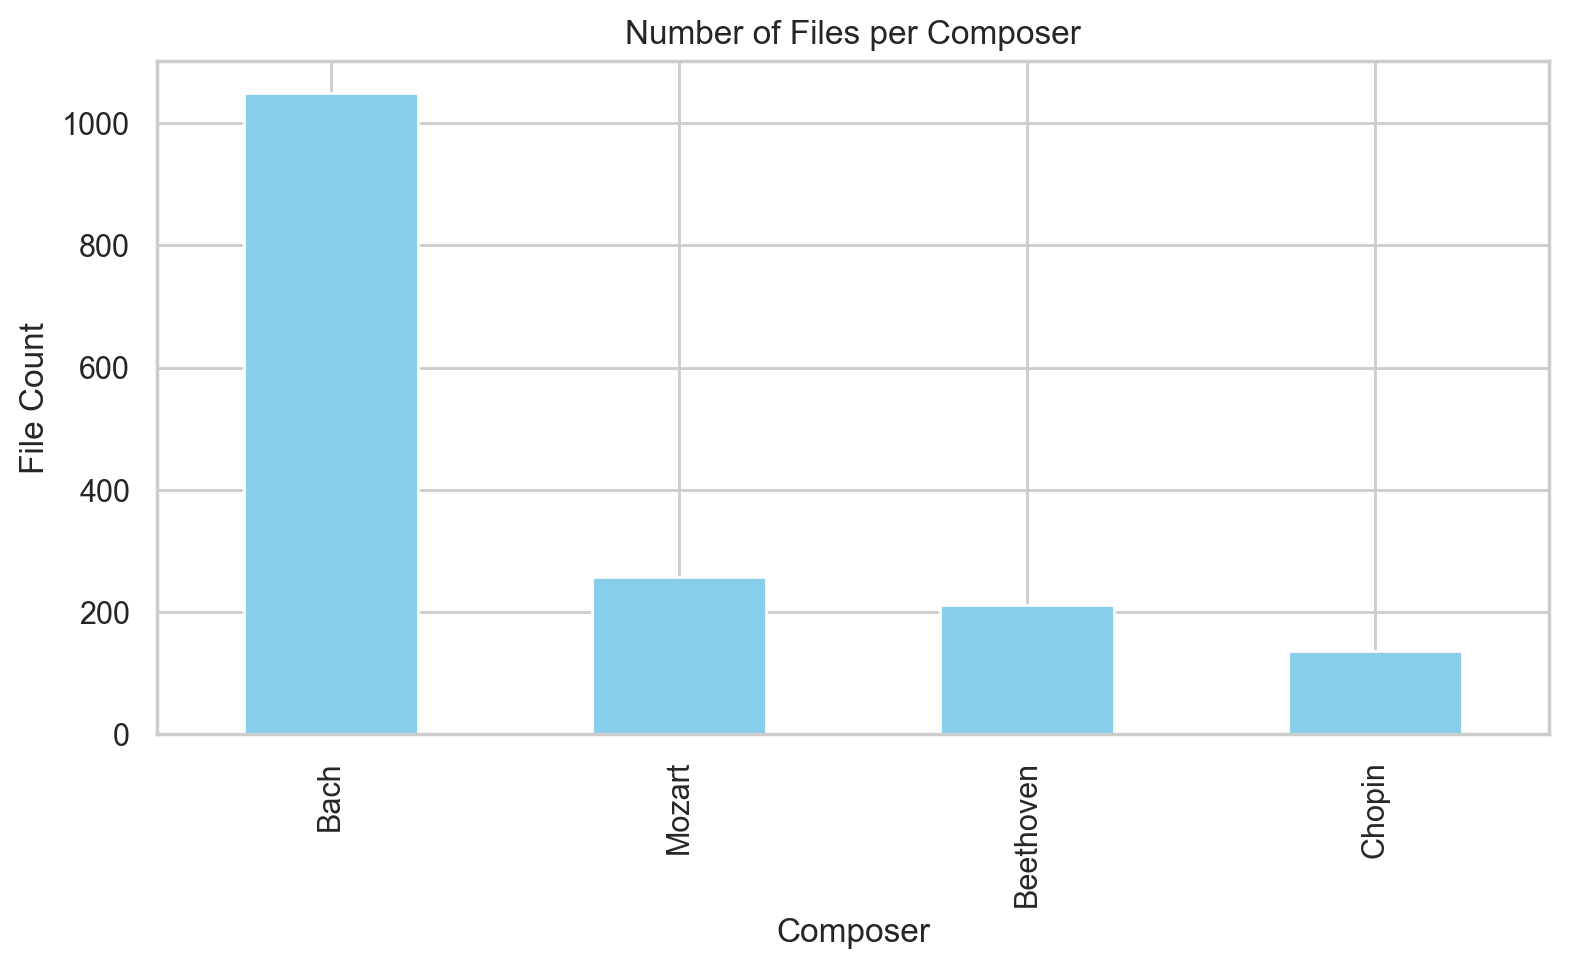

In [15]:
# Set plot style
sns.set(style="whitegrid")

# Number of files per composer
plt.figure(figsize=(8, 5))
composer_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Files per Composer')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.tight_layout()
plt.show()

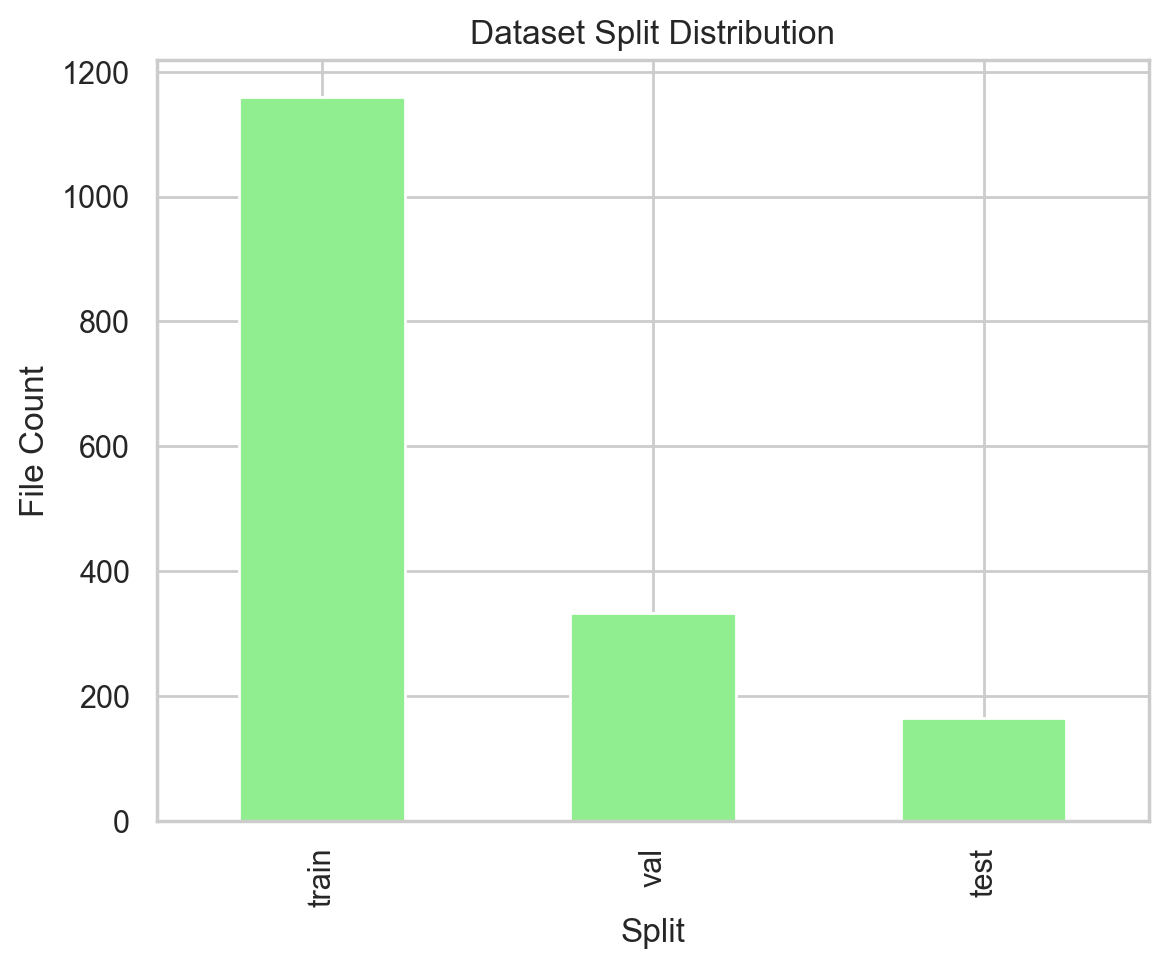

In [16]:
# Split distribution
plt.figure(figsize=(6, 5))
split_counts.plot(kind='bar', color='lightgreen')
plt.title('Dataset Split Distribution')
plt.ylabel('File Count')
plt.xlabel('Split')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

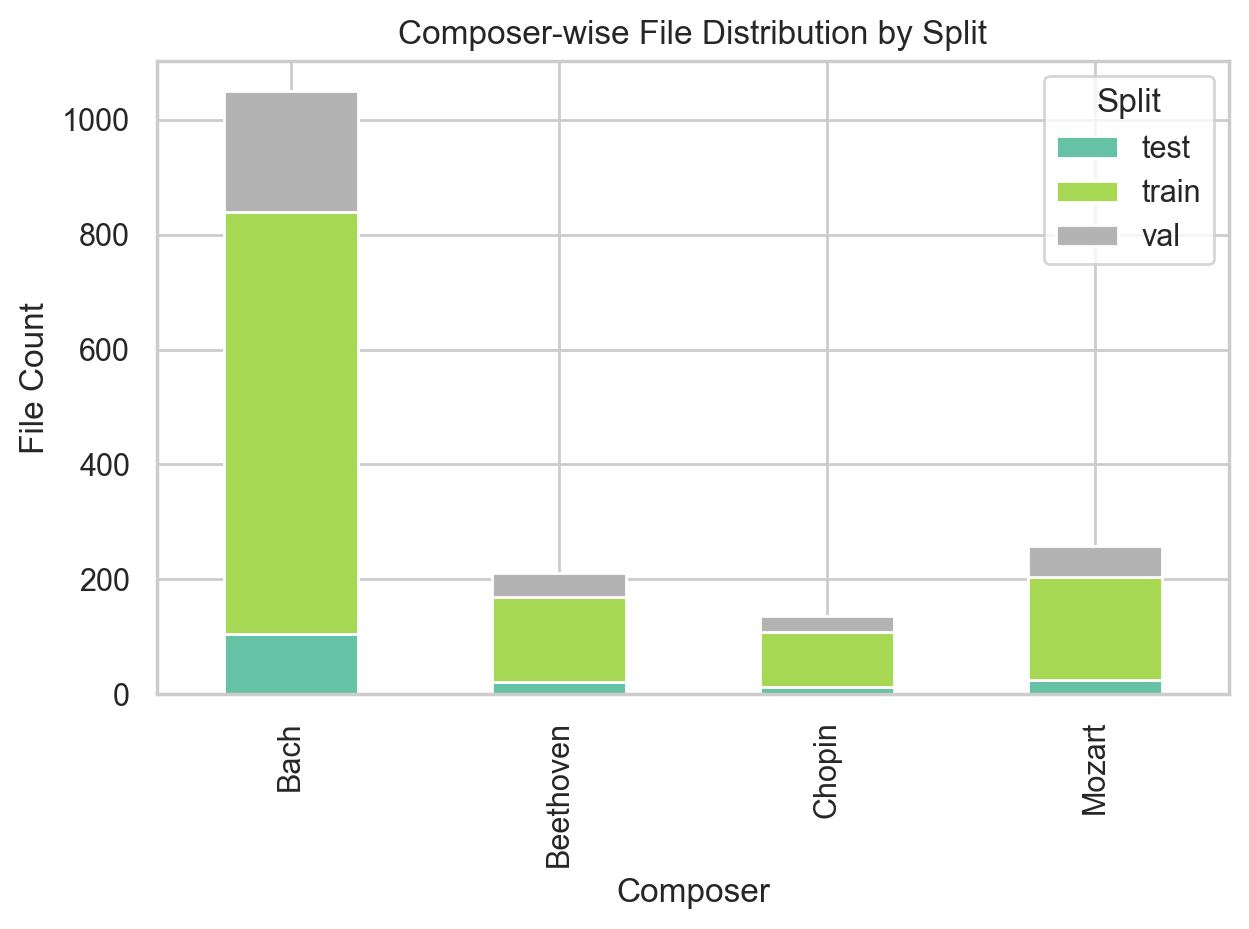

In [17]:
# Composer-wise split
plt.figure(figsize=(10, 6))
composer_split_counts.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Composer-wise File Distribution by Split')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

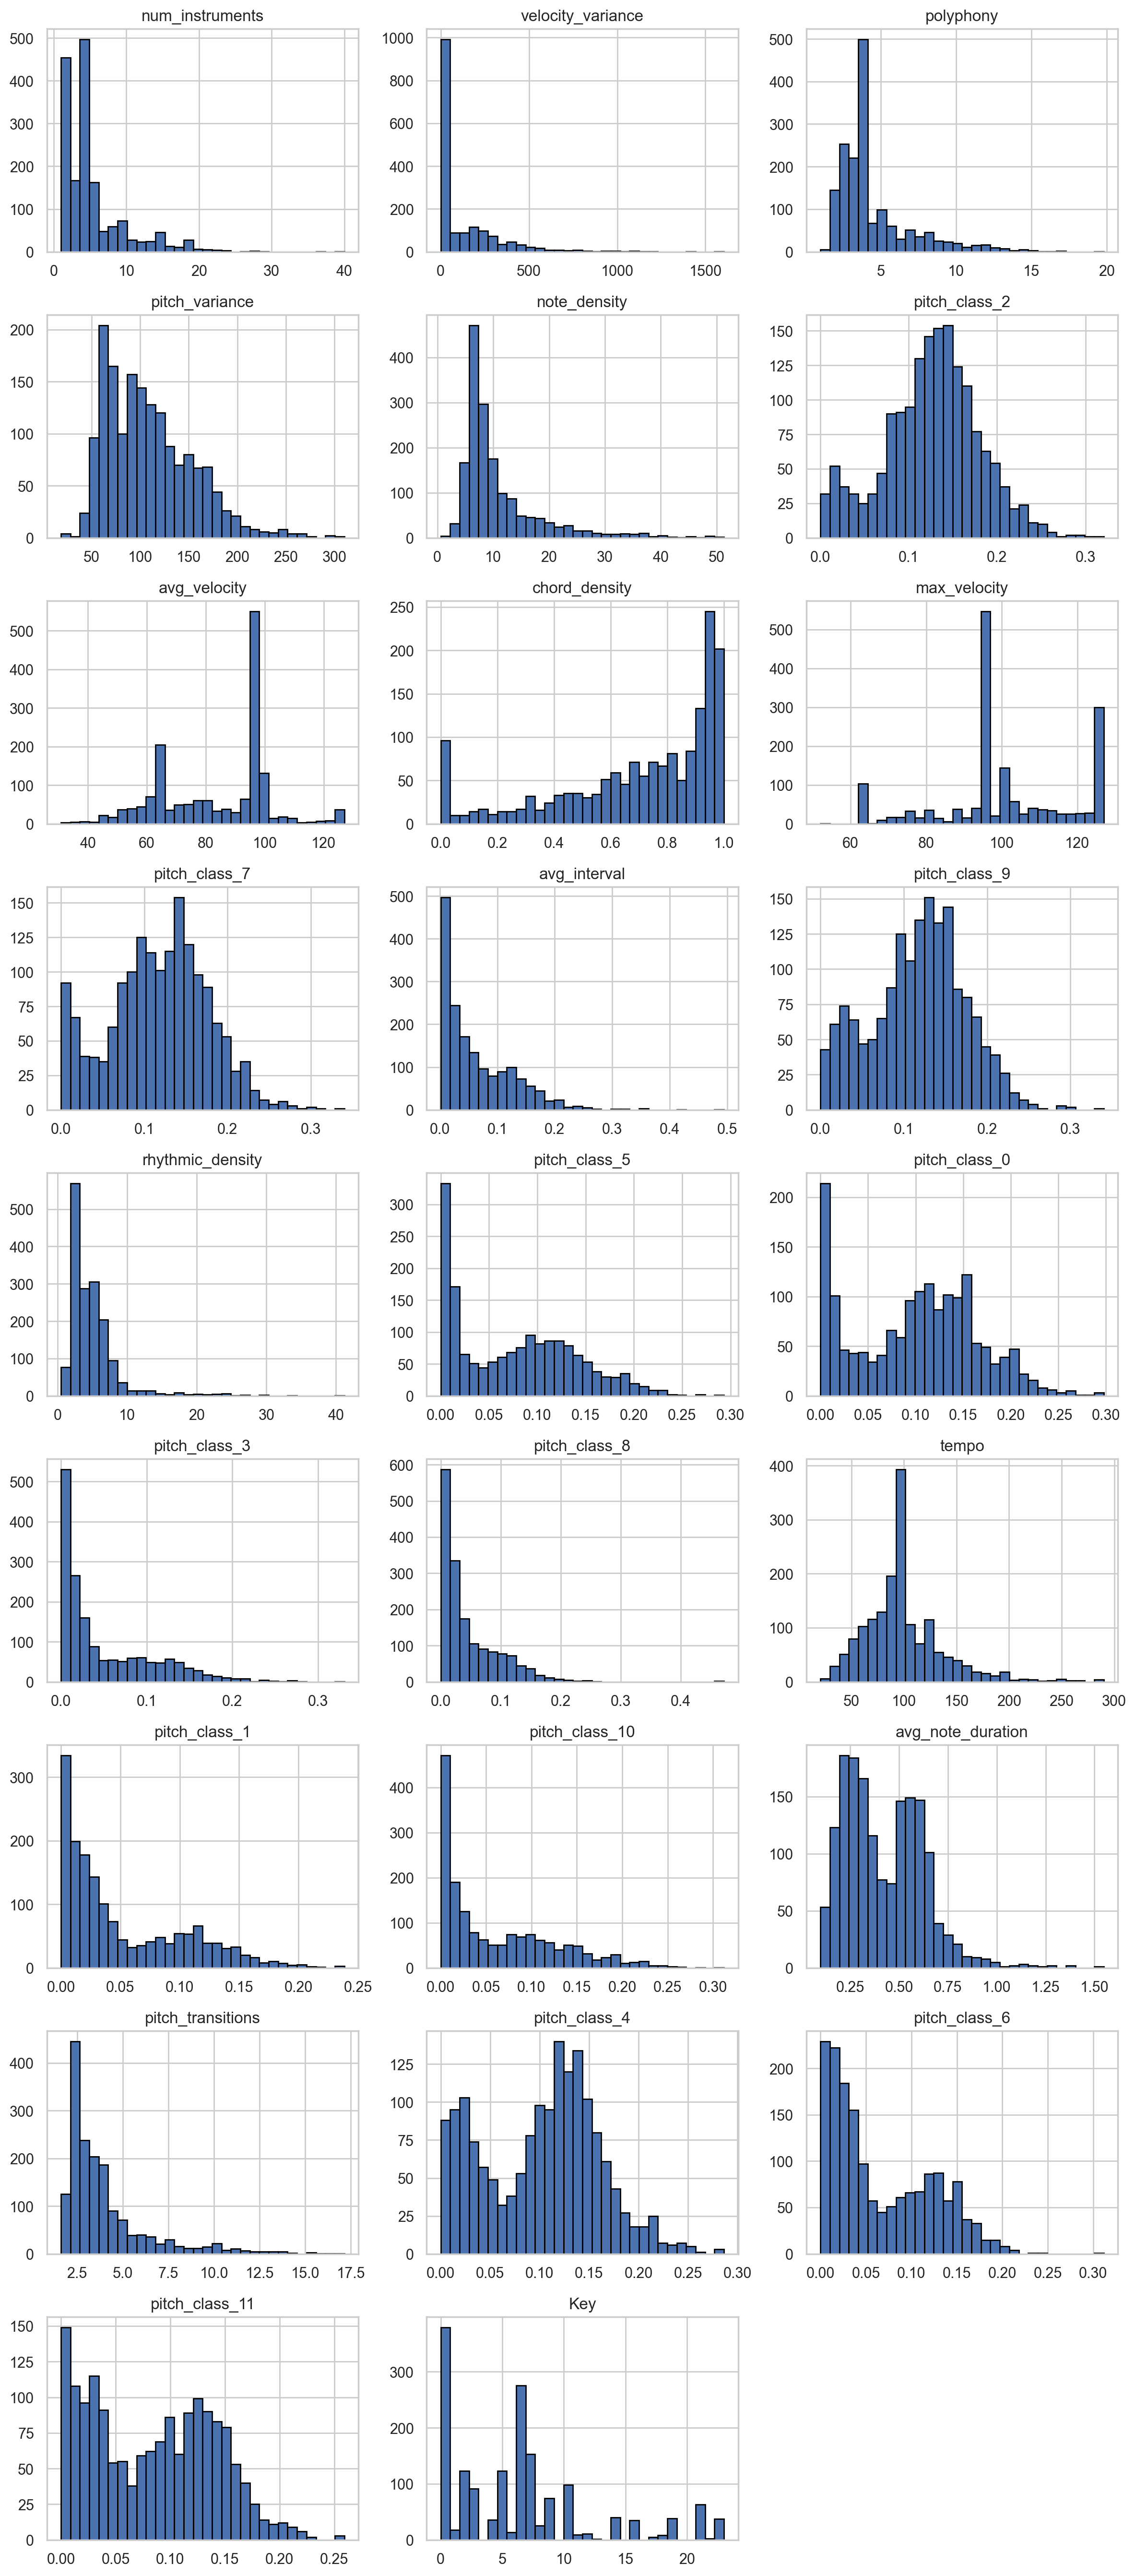

In [21]:
# Features to plot
features = [
    "num_instruments", "velocity_variance", "polyphony", "pitch_variance", "note_density",
    "pitch_class_2", "avg_velocity", "chord_density", "max_velocity", "pitch_class_7",
    "avg_interval", "pitch_class_9", "rhythmic_density", "pitch_class_5", "pitch_class_0",
    "pitch_class_3", "pitch_class_8", "tempo", "pitch_class_1", "pitch_class_10",
    "avg_note_duration", "pitch_transitions", "pitch_class_4", "pitch_class_6", "pitch_class_11",
    "Key"
]

# Determine grid dimensions for subplots
n_features = len(features)
ncols = 3
nrows = int(np.ceil(n_features / ncols))

plt.figure(figsize=(ncols * 4, nrows * 3))

# Plot distributions for each statistical feature
for i, feature in enumerate(features):
    plt.subplot(nrows, ncols, i + 1)
    data = df[feature].dropna()
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(feature)
    plt.tight_layout()

plt.show()

### Correlation analysis

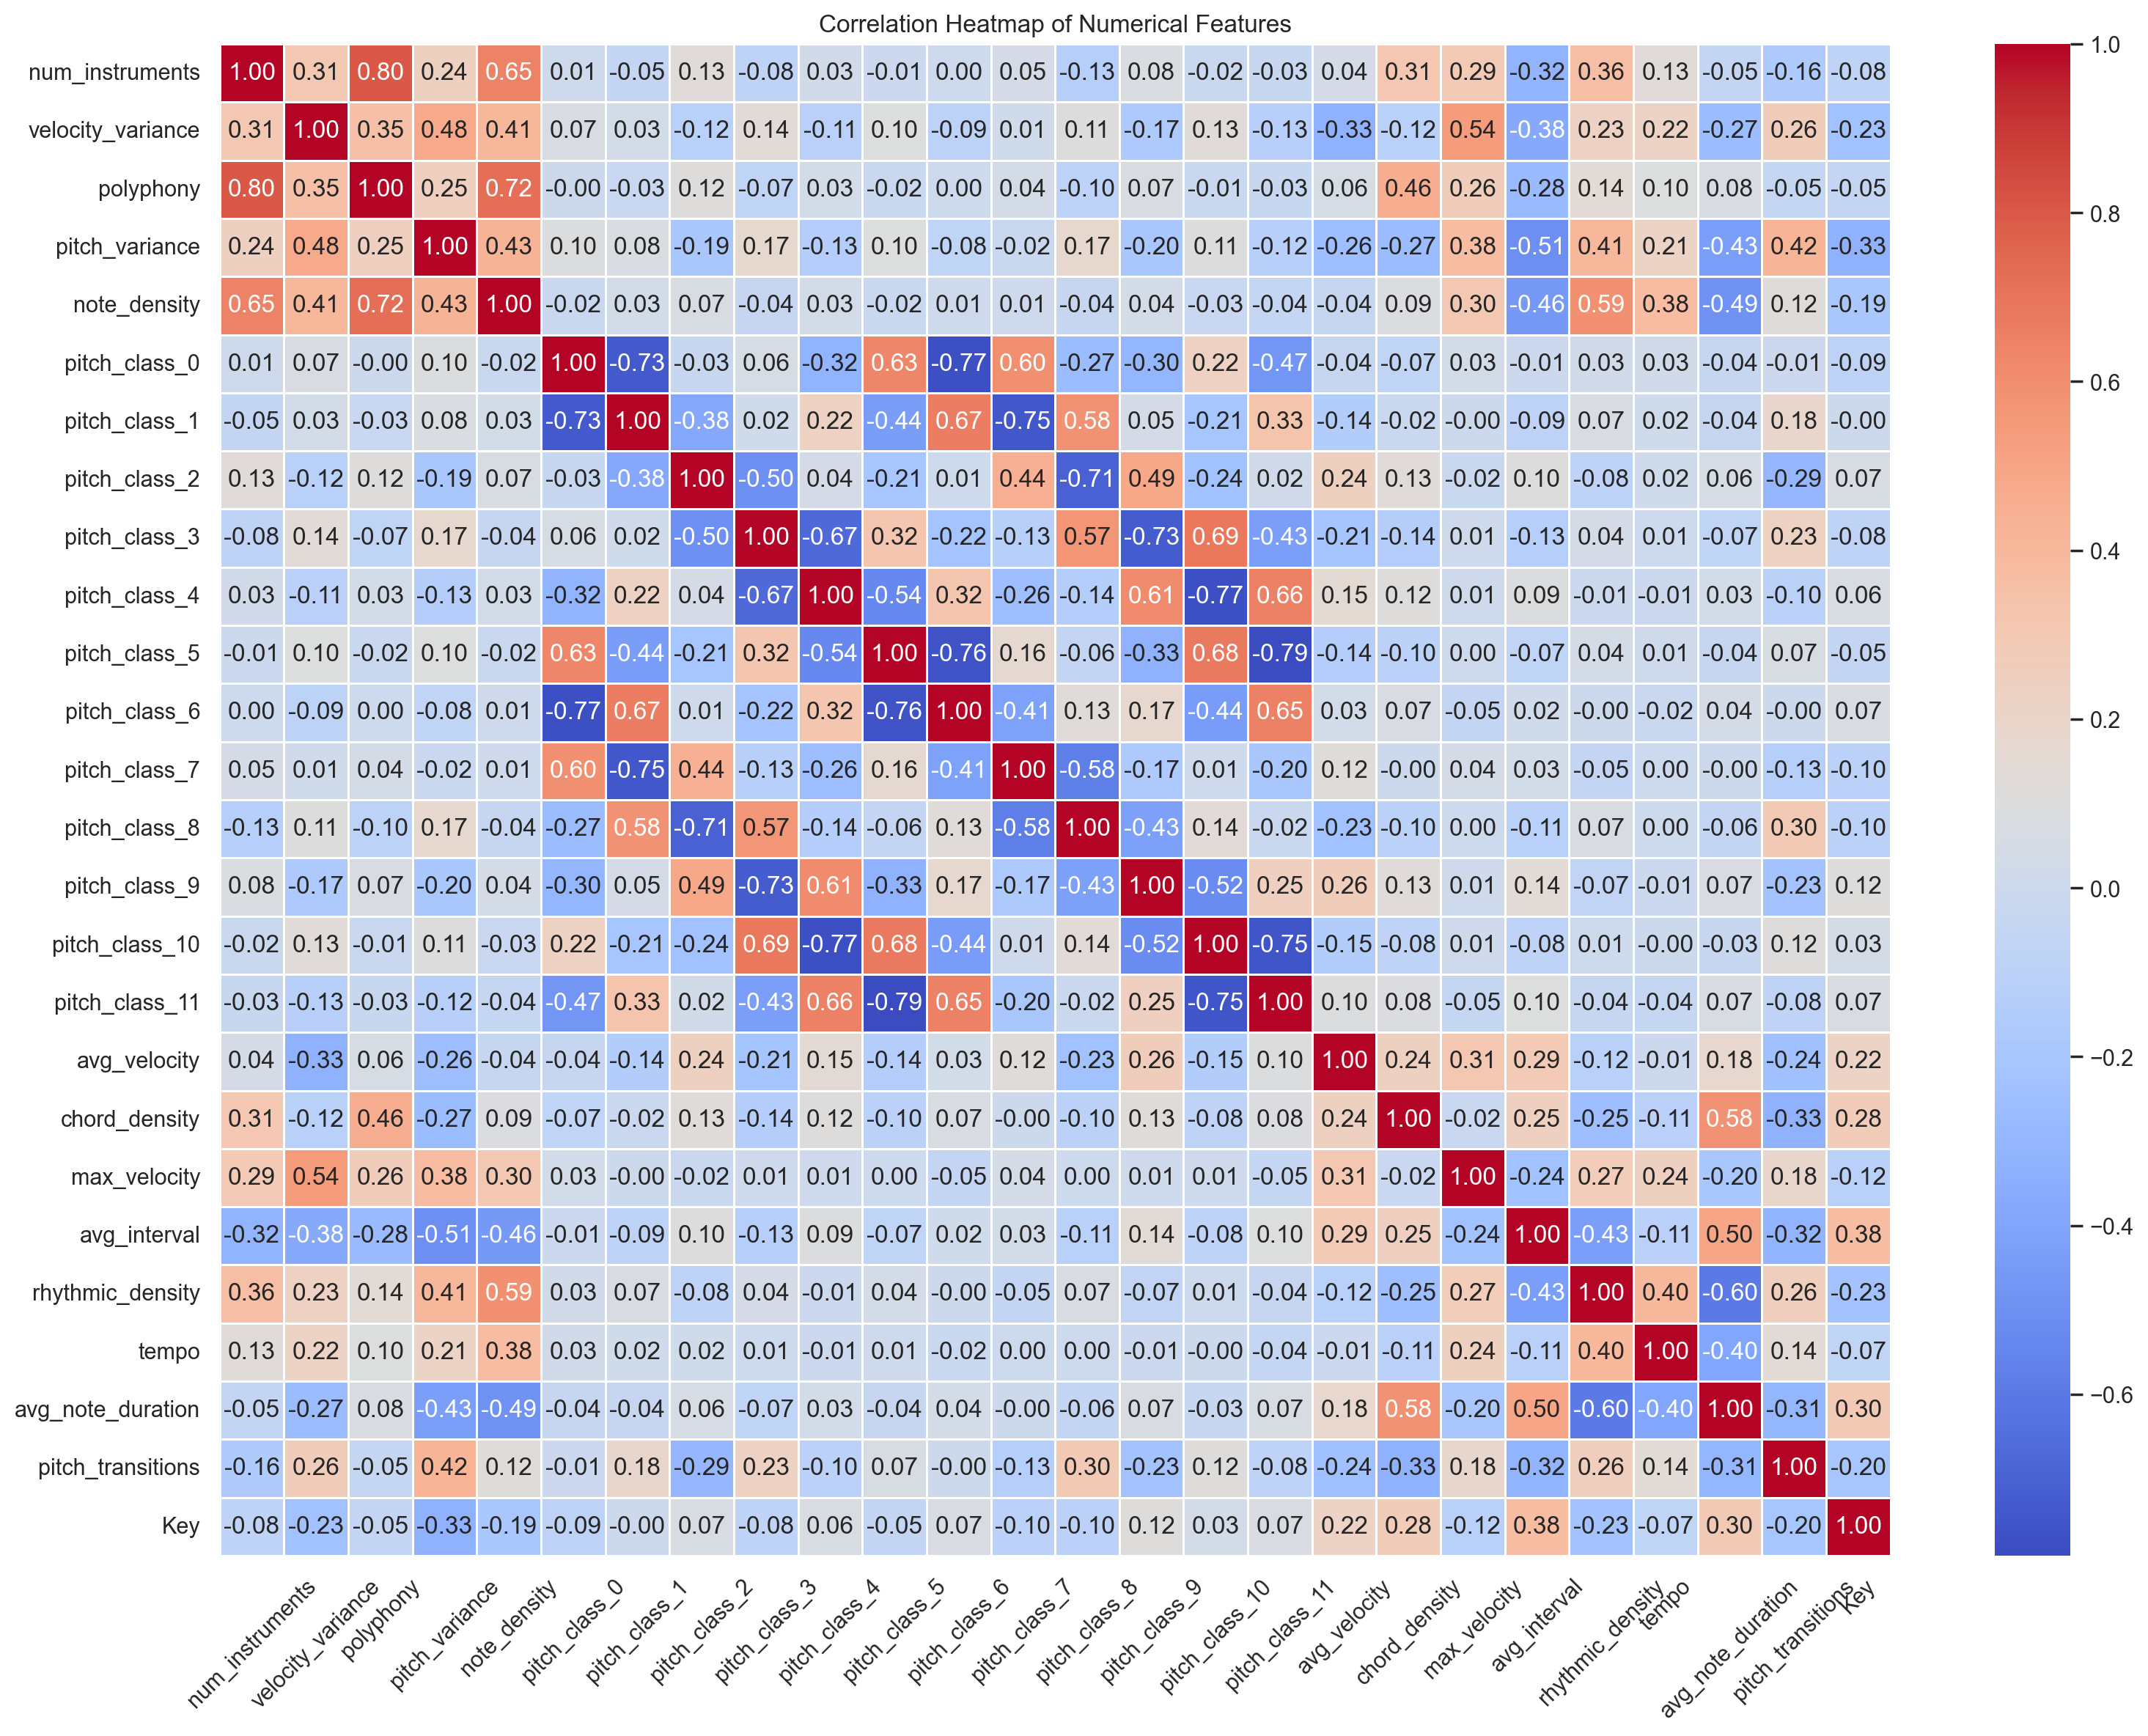

In [23]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

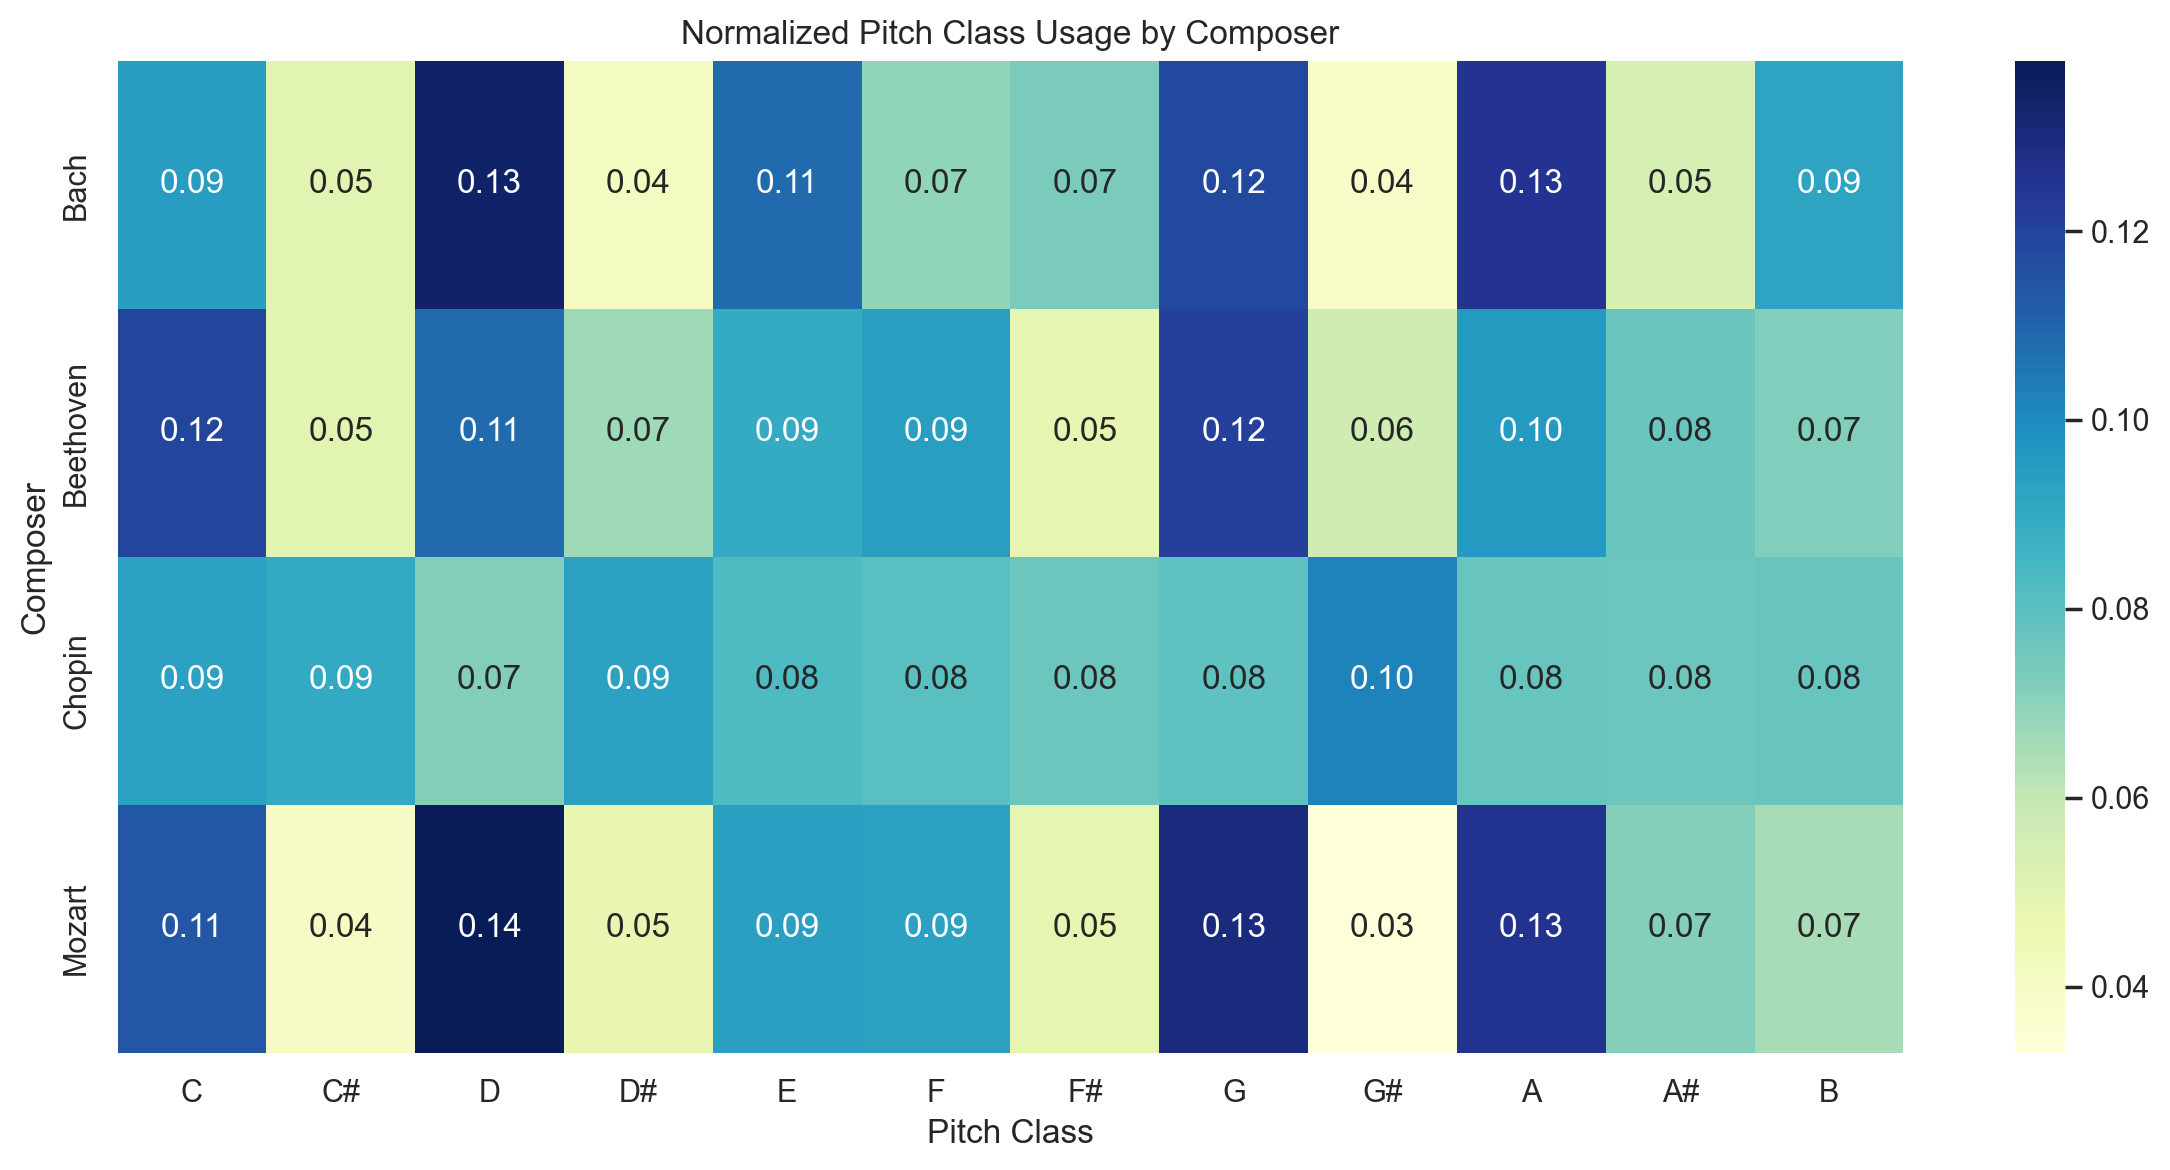

In [24]:
# Normalize pitch class usage by composer
pitch_classes = [f'pitch_class_{i}' for i in range(12)]
df_pitch = df.groupby('composer')[pitch_classes].mean()
df_pitch_normalized = df_pitch.div(df_pitch.sum(axis=1), axis=0)

# Rename columns to note names
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
df_pitch_normalized.columns = note_names

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(df_pitch_normalized, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Normalized Pitch Class Usage by Composer")
plt.xlabel("Pitch Class")
plt.ylabel("Composer")
plt.tight_layout()
plt.show()

## Model Building

### LSTM model

In [26]:
def create_sequences(data, targets, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(targets[i+seq_length])
    return np.array(X), np.array(y)

# Normalize the feature data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Encode labels (composer classification)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['composer'])

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length=5)

print("Input shape:", X_seq.shape)  
print("Target shape:", y_seq.shape)


Input shape: (1652, 5, 26)
Target shape: (1652,)


In [38]:

lstm_model = Sequential([
    Input(shape=(5, 26), dtype='int32'),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_seq)), activation='softmax')  # For classification
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,508 (99.64 KB)

 Trainable params: 25,508 (99.64 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

history = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3938 - loss: 1.3148 - val_accuracy: 0.8066 - val_loss: 0.8495
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8146 - loss: 0.7123 - val_accuracy: 0.8882 - val_loss: 0.3535
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8638 - loss: 0.4064 - val_accuracy: 0.9245 - val_loss: 0.2504
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9102 - loss: 0.2803 - val_accuracy: 0.9366 - val_loss: 0.1900
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9196 - loss: 0.2217 - val_accuracy: 0.9456 - val_loss: 0.1626
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1994 - val_accuracy: 0.9486 - val_loss: 0.1378
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9525 - loss: 0.1566 - val_accuracy: 0.9637 - val_loss: 0.1129
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.1898 - val_accuracy: 0.9607 - val_loss:

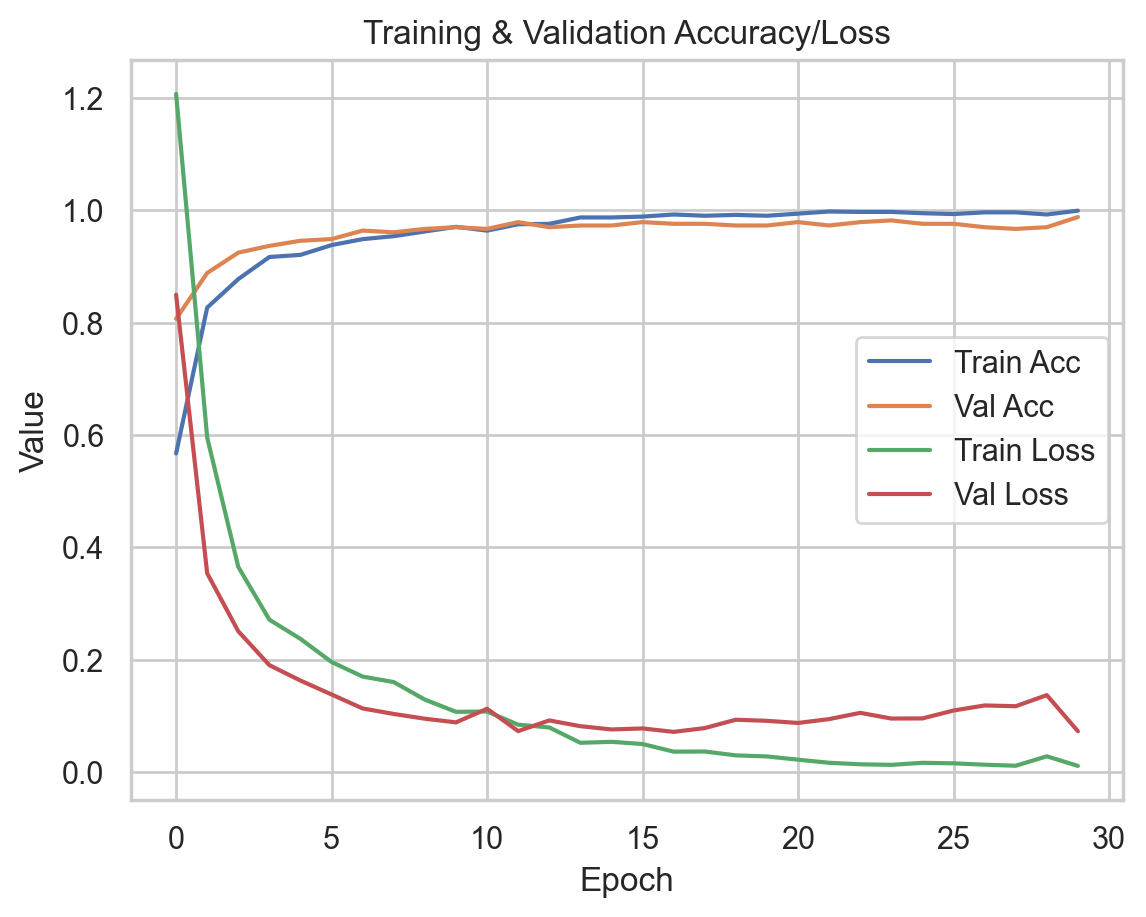

In [40]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [41]:

y_pred = lstm_model.predict(X_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00       210
   Beethoven       0.93      0.98      0.95        43
      Chopin       1.00      0.96      0.98        27
      Mozart       0.98      0.98      0.98        51

    accuracy                           0.99       331
   macro avg       0.98      0.98      0.98       331
weighted avg       0.99      0.99      0.99       331



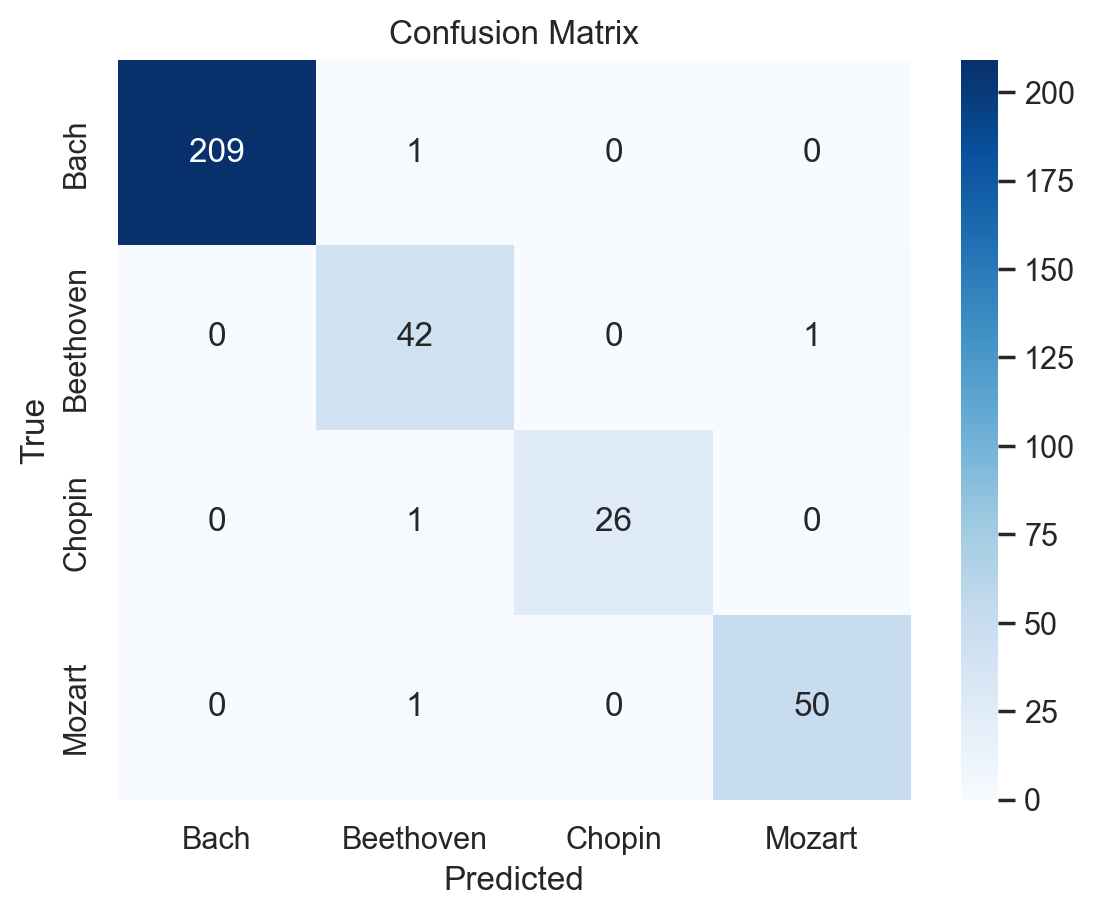

In [42]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Model Evaluation

## Model Optimization